In [1]:
from matplotlib import pyplot as plt 
import numpy as np

import os

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

In [3]:
from torchvision import datasets
from torchvision import transforms

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='mps')

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [6]:
train_dataset = datasets.FashionMNIST(root="data", train=True,download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="data", train=False,download=True, transform=transform)

In [7]:
print(train_dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
n_classes = len(train_dataset.classes)
n_classes

10

In [9]:
image, label = train_dataset[0] # type: ignore
type(image), image.shape, type(label)

(torch.Tensor, torch.Size([1, 28, 28]), int)

Ankle boot


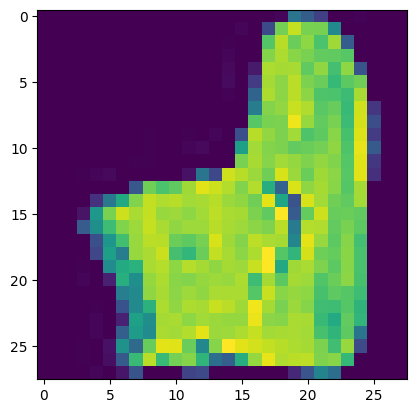

In [10]:
print(train_dataset.classes[label])
plt.imshow(image.transpose(0,2))

In [11]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3,padding=1)
        self.relu = nn.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=2)

    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pooling(x)
        return x

In [13]:
class CNNModel(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        self.block_1 = CNNBlock(1, 10)
        self.block_2 = CNNBlock(10, 5)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(5 * 7 * 7, n_classes),
        )

    def forward(self, x):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x

In [14]:
model = CNNModel().to(device)

In [15]:
model_name = "mnistFashion.pth"


In [16]:
if os.path.exists("model_name"):
    model.load_state_dict(torch.load(model_name))

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [18]:
def train_epoch(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    device=device,
) -> float:
    model.to(device)
    model.train()

    train_losses = []
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    return np.mean(train_losses)  # type: ignore

In [19]:
num_epochs = 20
losses = []
best_score = torch.inf
for epoch in range(num_epochs):
    loss = train_epoch()
    print(f"Epoch {epoch + 1}: {loss}")
    losses.append(loss)

Epoch 1: 0.6065696958382925
Epoch 2: 0.41859497139851254
Epoch 3: 0.38058725038369495
Epoch 4: 0.3598601862668991
Epoch 5: 0.34330298177401225
Epoch 6: 0.3318814043164253
Epoch 7: 0.32440759309927625
Epoch 8: 0.3176719740788142
Epoch 9: 0.31212782821059226
Epoch 10: 0.3069311995426814
Epoch 11: 0.3030552168349425
Epoch 12: 0.29936154100497564
Epoch 13: 0.2954609654088815
Epoch 14: 0.2915873514831066
Epoch 15: 0.288971322508653
Epoch 16: 0.2863376935640971
Epoch 17: 0.28447531589269637
Epoch 18: 0.28197166391412415
Epoch 19: 0.27964492537180585
Epoch 20: 0.27681267906824747


In [20]:
torch.save(model.state_dict(), model_name)

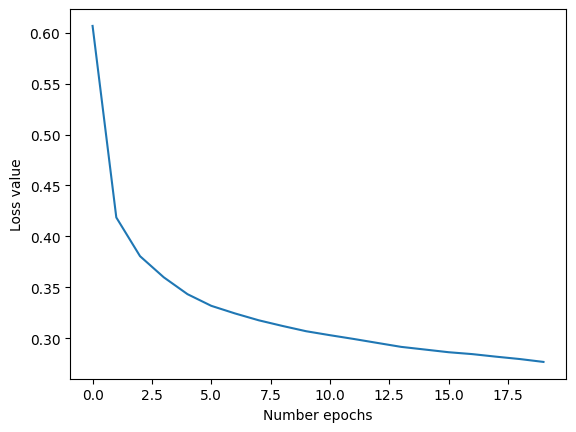

In [21]:
plt.plot(losses)
plt.xlabel("Number epochs")
plt.ylabel("Loss value")
plt.show()

In [22]:
def accuracy_evaluation(model, dataloader):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, dim = 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [23]:
accuracy = accuracy_evaluation(model, test_loader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 89.03%


In [24]:
accuracy = accuracy_evaluation(model, train_loader)
print(f"Train Accuracy: {accuracy:.2f}%")

Train Accuracy: 90.49%
